# Object Tracking (Single Object)

## Task 3: Classical Object Tracking using OpenCV

by Dechathon Niamsa-ard [st126235]

**Goal:** Implement traditional tracking algorithms using OpenCV.

**Suggested Trackers:**

- KCF
- CSRT
- MOSSE

**Instructions:**

1. Use a **short video** (e.g., pedestrians, cars, or sports).
- You can download public videos from [Pexels Videos] or [MOT Challenge dataset].
2. Define an initial bounding box.
3. Apply **two different OpenCV trackers** (e.g., KCF and CSRT).
4. Compare:
- Tracking stability
- Frame rate (FPS)
- Failure cases (drift, loss, occlusion)

**Deliverables:**

- Output video or GIF with tracking visualization
- Comparison table (FPS, success rate, drift cases)
- Short discussion on performance trade-offs

---


## Import necessary libraries

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import sys
import time 

## Setup config

In [2]:
# Set up OUTPUT_DIR
OUTPUT_DIR = './files_task3/'
test_video_path = './files_task3/test_video.mp4'

In [3]:
# Create OUTPUT_DIR if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

In [4]:
# Set up name of the output video file for each type of detection

# KCF Tracker output video file
kcf_output_video_path = os.path.join(OUTPUT_DIR, 'kcf_output_video.mp4')
# CSRT Tracker output video file
csrt_output_video_path = os.path.join(OUTPUT_DIR, 'csrt_output_video.mp4')
# MOSSE Tracker output video file
mosse_output_video_path = os.path.join(OUTPUT_DIR, 'mosse_output_video.mp4')

## Download short video

In [5]:
# Load the video
video = cv2.VideoCapture(test_video_path)
if not video.isOpened():
    print("Error: Could not open video.")
    sys.exit()

## Define initial bounding box

In [6]:
# Read the first frame
ret, frame = video.read()
if not ret:
    print("Error: Could not read the first frame.")
    sys.exit()

# Let user select the ROI (Region of Interest) manually
print("Select the object to track, then press ENTER or SPACE")
bbox = cv2.selectROI("Select Object", frame, False)
cv2.destroyAllWindows()

print(f"Selected bounding box: {bbox}")

# Reset video to the beginning
video.set(cv2.CAP_PROP_POS_FRAMES, 0)

Select the object to track, then press ENTER or SPACE
Selected bounding box: (650, 667, 208, 242)


True

## Apply different OpenCV trackers (KCF, CSRT, MOSSE)

In [7]:
def track_object(video_path, bbox, tracker_type, output_path):
    """
    Track object using specified tracker type
    
    Args:
        video_path: Path to input video
        bbox: Initial bounding box (x, y, w, h)
        tracker_type: Type of tracker ('KCF', 'CSRT', or 'MOSSE')
        output_path: Path to save output video
    
    Returns:
        Dictionary with tracking metrics
    """
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Create tracker based on type
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    elif tracker_type == 'CSRT':
        tracker = cv2.TrackerCSRT_create()
    elif tracker_type == 'MOSSE':
        tracker = cv2.legacy.TrackerMOSSE_create()
    else:
        raise ValueError(f"Unknown tracker type: {tracker_type}")
    
    # Read first frame
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read video for {tracker_type}")
        return None
    
    # Initialize tracker with first frame and bounding box
    tracker.init(frame, bbox)
    
    # Tracking metrics
    frame_count = 0
    success_count = 0
    failure_count = 0
    processing_times = []
    
    print(f"\n{'='*50}")
    print(f"Tracking with {tracker_type}")
    print(f"{'='*50}")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Start timer
        start_time = time.time()
        
        # Update tracker
        success, box = tracker.update(frame)
        
        # End timer
        end_time = time.time()
        processing_times.append(end_time - start_time)
        
        # Draw bounding box
        if success:
            success_count += 1
            # Tracking success
            x, y, w, h = [int(v) for v in box]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{tracker_type}: Tracking", (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        else:
            failure_count += 1
            # Tracking failure
            cv2.putText(frame, f"{tracker_type}: Lost", (50, 80),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        # Calculate and display FPS
        current_fps = 1.0 / (end_time - start_time)
        cv2.putText(frame, f"FPS: {current_fps:.2f}", (50, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
        
        # Display frame number
        cv2.putText(frame, f"Frame: {frame_count}/{total_frames}", (50, height - 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        # Write frame to output video
        out.write(frame)
        
        # Progress indicator
        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames} frames...")
    
    # Release resources
    cap.release()
    out.release()
    
    # Calculate metrics
    avg_fps = 1.0 / np.mean(processing_times)
    success_rate = (success_count / frame_count) * 100
    
    metrics = {
        'tracker_type': tracker_type,
        'total_frames': frame_count,
        'success_count': success_count,
        'failure_count': failure_count,
        'success_rate': success_rate,
        'avg_fps': avg_fps,
        'min_fps': 1.0 / np.max(processing_times),
        'max_fps': 1.0 / np.min(processing_times)
    }
    
    print(f"\n{tracker_type} Tracking Complete!")
    print(f"Total Frames: {frame_count}")
    print(f"Success: {success_count}, Failures: {failure_count}")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average FPS: {avg_fps:.2f}")
    print(f"Output saved to: {output_path}")
    
    return metrics


# Track with all three trackers
print("Starting object tracking with multiple trackers...")
print("This may take a few minutes depending on video length...\n")

# Track with KCF
kcf_metrics = track_object(test_video_path, bbox, 'KCF', kcf_output_video_path)

# Reset video and track with CSRT
csrt_metrics = track_object(test_video_path, bbox, 'CSRT', csrt_output_video_path)

# Reset video and track with MOSSE
mosse_metrics = track_object(test_video_path, bbox, 'MOSSE', mosse_output_video_path)

print("\n" + "="*50)
print("ALL TRACKING COMPLETE!")
print("="*50)

Starting object tracking with multiple trackers...
This may take a few minutes depending on video length...


Tracking with KCF
Processed 30/216 frames...
Processed 60/216 frames...
Processed 90/216 frames...
Processed 120/216 frames...
Processed 150/216 frames...
Processed 180/216 frames...
Processed 210/216 frames...

KCF Tracking Complete!
Total Frames: 215
Success: 215, Failures: 0
Success Rate: 100.00%
Average FPS: 96.18
Output saved to: ./files_task3/kcf_output_video.mp4

Tracking with CSRT
Processed 30/216 frames...
Processed 60/216 frames...
Processed 90/216 frames...
Processed 120/216 frames...
Processed 150/216 frames...
Processed 180/216 frames...
Processed 210/216 frames...

CSRT Tracking Complete!
Total Frames: 215
Success: 215, Failures: 0
Success Rate: 100.00%
Average FPS: 52.33
Output saved to: ./files_task3/csrt_output_video.mp4

Tracking with MOSSE
Processed 30/216 frames...
Processed 60/216 frames...
Processed 90/216 frames...
Processed 120/216 frames...
Processed 15

## Make Comparison
- Tracking stability
- Frame rate (FPS)
- Failure cases (drift, loss, occlusion)


TRACKER PERFORMANCE COMPARISON
Tracker  Total Frames  Success Count  Failure Count Success Rate (%) Avg FPS Min FPS Max FPS
    KCF           215            215              0           100.00   96.18   56.12  127.99
   CSRT           215            215              0           100.00   52.33   21.96   70.90
  MOSSE           215            215              0           100.00  656.15  277.05  787.07

Comparison table saved to: ./files_task3/tracker_comparison.csv
Comparison plot saved to: ./files_task3/tracker_comparison.png


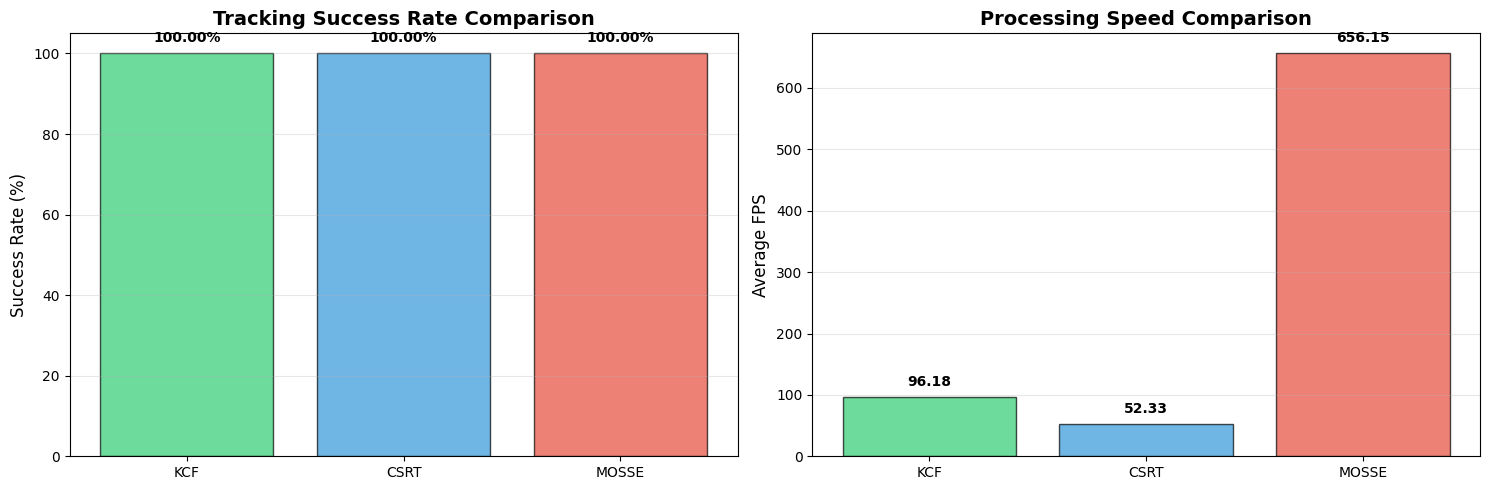


PERFORMANCE SUMMARY
✓ Best Tracking Accuracy: KCF (100.00%)
✓ Fastest Processing: MOSSE (656.15 FPS)

Output Videos:
  - KCF: ./files_task3/kcf_output_video.mp4
  - CSRT: ./files_task3/csrt_output_video.mp4
  - MOSSE: ./files_task3/mosse_output_video.mp4


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison table
comparison_data = {
    'Tracker': [kcf_metrics['tracker_type'], csrt_metrics['tracker_type'], mosse_metrics['tracker_type']],
    'Total Frames': [kcf_metrics['total_frames'], csrt_metrics['total_frames'], mosse_metrics['total_frames']],
    'Success Count': [kcf_metrics['success_count'], csrt_metrics['success_count'], mosse_metrics['success_count']],
    'Failure Count': [kcf_metrics['failure_count'], csrt_metrics['failure_count'], mosse_metrics['failure_count']],
    'Success Rate (%)': [f"{kcf_metrics['success_rate']:.2f}", 
                         f"{csrt_metrics['success_rate']:.2f}", 
                         f"{mosse_metrics['success_rate']:.2f}"],
    'Avg FPS': [f"{kcf_metrics['avg_fps']:.2f}", 
                f"{csrt_metrics['avg_fps']:.2f}", 
                f"{mosse_metrics['avg_fps']:.2f}"],
    'Min FPS': [f"{kcf_metrics['min_fps']:.2f}", 
                f"{csrt_metrics['min_fps']:.2f}", 
                f"{mosse_metrics['min_fps']:.2f}"],
    'Max FPS': [f"{kcf_metrics['max_fps']:.2f}", 
                f"{csrt_metrics['max_fps']:.2f}", 
                f"{mosse_metrics['max_fps']:.2f}"]
}

df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "="*80)
print("TRACKER PERFORMANCE COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Save comparison table to CSV
comparison_csv_path = os.path.join(OUTPUT_DIR, 'tracker_comparison.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"\nComparison table saved to: {comparison_csv_path}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Success Rate Comparison
trackers = [kcf_metrics['tracker_type'], csrt_metrics['tracker_type'], mosse_metrics['tracker_type']]
success_rates = [kcf_metrics['success_rate'], csrt_metrics['success_rate'], mosse_metrics['success_rate']]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(trackers, success_rates, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Success Rate (%)', fontsize=12)
axes[0].set_title('Tracking Success Rate Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 105])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(success_rates):
    axes[0].text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Average FPS Comparison
avg_fps_values = [kcf_metrics['avg_fps'], csrt_metrics['avg_fps'], mosse_metrics['avg_fps']]

axes[1].bar(trackers, avg_fps_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Average FPS', fontsize=12)
axes[1].set_title('Processing Speed Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(avg_fps_values):
    axes[1].text(i, v + max(avg_fps_values)*0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
comparison_plot_path = os.path.join(OUTPUT_DIR, 'tracker_comparison.png')
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
print(f"Comparison plot saved to: {comparison_plot_path}")
plt.show()

# Performance summary
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

# Find best tracker for each metric
best_success = max([(kcf_metrics, 'KCF'), (csrt_metrics, 'CSRT'), (mosse_metrics, 'MOSSE')], 
                   key=lambda x: x[0]['success_rate'])
best_speed = max([(kcf_metrics, 'KCF'), (csrt_metrics, 'CSRT'), (mosse_metrics, 'MOSSE')], 
                 key=lambda x: x[0]['avg_fps'])

print(f"✓ Best Tracking Accuracy: {best_success[1]} ({best_success[0]['success_rate']:.2f}%)")
print(f"✓ Fastest Processing: {best_speed[1]} ({best_speed[0]['avg_fps']:.2f} FPS)")
print(f"\nOutput Videos:")
print(f"  - KCF: {kcf_output_video_path}")
print(f"  - CSRT: {csrt_output_video_path}")
print(f"  - MOSSE: {mosse_output_video_path}")
print("="*80)

## Short discussion on performance trade-offs

Video I have used is Video by Robin Neu-Breitmayer from Pexels: https://www.pexels.com/video/a-car-travelling-in-a-road-built-at-lakeside-3065047/

MOSSE is extremely fast (≈656 FPS in this run), so it is ideal when real-time speed and low CPU/GPU use are the priority. However, MOSSE usually has weaker robustness to scale changes, partial occlusion, and background distractors. In harder scenes, it can drift more easily, so it suits simple motion and stable lighting.

KCF offers a good balance. It delivered solid speed (≈96 FPS) and very stable tracking here (100% success on the clip). KCF can still drift during long occlusions or when the object changes scale quickly, but compared with MOSSE it tends to be more reliable, while staying efficient for real-time applications.

CSRT focuses on accuracy. It was the slowest in this test (≈52 FPS), but it typically handles scale variation and background clutter better, thanks to its more selective features and segmentation. The cost is higher latency and compute. In scenes with occlusions, overlaps, or similar objects nearby, CSRT often keeps the box tighter and reduces drift.

In my opinion, pick MOSSE for maximum speed on easy scenes; choose KCF for general-purpose real-time use; prefer CSRT when the scene is challenging and accuracy is more important than throughput. Note that all three reached 100% success on this particular video, which suggests the sequence was not very challenging; harder footage would likely show clearer gaps between them.